In [59]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.preprocessing import LabelEncoder

import pandas as pd, xgboost, numpy as np, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [60]:
data = pd.read_csv("./data.csv")
data.columns = ["URL", "Text", "Start-Indices", "End-Indices", "Text-Type"]
#data["Text-Type"] = 5
data.head()

,URL,Text,Start-Indices,End-Indices,Text-Type
0,https://stackoverflow.com/questions/37958781,So does that mean it is better than the defaul...,[],[],0
1,https://stackoverflow.com/questions/37958781,It is fundamentally a heuristic based approach...,[],[],0
2,https://stackoverflow.com/questions/37958781,Calling it a heuristic approach is not meant t...,[],[],0
3,https://stackoverflow.com/questions/37958781,"The text in question was Moby Dick, and the od...",[],[],0
4,https://stackoverflow.com/questions/37958783,A table containing only debit and credit colum...,[],[],0


In [61]:
import csv
import nltk
import re
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [62]:
trainDF = pd.DataFrame()
trainDF['text'] = data["Text"]
trainDF['label'] = data["Text-Type"]

In [63]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])

In [64]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [65]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [66]:
import tensorflow as tf
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    #################################################################################
    # Before fitting the classifier
#     feature_vector_train_reordered = tf.sparse.reorder(feature_vector_train)
#     feature_vector_valid_reordered = tf.sparse.reorder(feature_vector_valid)

#     # Inside the train_model function
#     classifier.fit(feature_vector_train_reordered, label)

#     # Predict the labels on validation dataset
#     predictions = classifier.predict(feature_vector_valid_reordered)
    #################################################################################
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [67]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_count, train_y, xvalid_count)

In [68]:
print(accuracy)

0.9331075359864521


In [69]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r"(?u)\b\w\w+\b", ngram_range=(2,3), max_features=5000)
# tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

In [70]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return classifier 

# classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])

# accuracy = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, is_neural_net=True)
# print ("NN, Ngram Level TF IDF Vectors",accuracy)

In [71]:
sentence_corpus=[]
for sentence in trainDF["text"]:
    sentence_corpus.append(nltk.word_tokenize(sentence))

In [72]:
print(sentence_corpus[0])

['So', 'does', 'that', 'mean', 'it', 'is', 'better', 'than', 'the', 'default', 'one', '?', 'Or', 'what', 'is', 'the', 'standard', 'of', 'comparison', 'among', 'various', 'tokenizers', '?']


In [73]:
import sys
!{sys.executable} -m pip install gensim

In [74]:
import gensim
model = gensim.models.Word2Vec(sentence_corpus, min_count=1,vector_size=300,workers=4)

In [75]:
print(model.wv.similarity('class', 'public'))

0.8880378


In [76]:
print(list(model.wv.index_to_key))

[',', '(', ')', 'the', '.', ';', "''", 'to', '<', 'a', '>', ':', 'of', 'and', '=', 'in', '{', '[', ']', '}', '``', 'is', "'", 'that', 'for', 'I', '$', 'it', '’', '*', 'if', 'i', 'on', 's', 'with', 'you', 'as', 'int', '#', 'The', 'was', 'not', 'this', 'have', '0', 'be', '?', 'from', 'Mr.', 'said', 'an', '1', 'by', 'are', 'at', 'return', '!', 'can', 'he', 'but', 'or', '@', '&', 'will', '--', 'has', 'function', 'which', 'his', '2', 'your', '/', 'new', '%', 'android', 'had', 'public', '//', '+', 'do', 'var', 'who', 'data', 'using', 'one', '—', 'would', 'j', 'they', 'use', 'like', 'In', 'my', 'n', '-', 'all', 'when', 'else', 'were', 'about', 'long', 'It', 'more', 'But', 't', 'their', 'want', 'there', "n't", 'its', "'s", 'value', 'so', 'A', 'code', 'get', 'class', 'some', 'void', 'we', 'out', 'been', 'then', 'what', 'after', 'also', 'Trump', 'node', 'need', 'into', 'first', 'just', 'other', '==', 'while', 'time', 'up', 'You', 'than', 'x', 'name', 'class=', 'her', 'any', 'lt', 'only', '3', 'T

In [77]:
print(model.wv['include'])

[-0.36695948  0.21211433  0.7780809  -0.55631506  0.15487862 -0.04851115
  0.9494361   0.12515663  0.46014604 -0.00582233 -0.07680964 -0.28663287
 -0.66779244 -1.8969167   0.05119026 -0.04058389  1.199793    0.6057376
  0.0393936   0.669629   -0.18135913 -0.01185076 -0.46732032 -0.7307058
  0.13106948  0.8865293   0.08572622 -0.656721    0.4020531  -0.67863244
  0.2578252   0.2595674  -0.44651788 -0.07710473  0.18928279 -0.08092143
  1.1125876  -0.19035873  0.31488997  0.5904287   0.41811562  0.51453435
  0.53005785 -0.12594771 -0.9213122  -0.22042643  1.2067053   0.6425426
 -1.5918826   0.4301693  -0.60468316  0.4516785  -0.2725635  -0.5056038
 -0.23608826  0.72216755  0.18041877  0.45870823  0.27415243  0.5810092
 -0.32274625  0.38532782 -0.14413242 -0.75249654 -0.06057589  0.5469506
 -0.7659066   0.35288867 -0.5446795  -0.49842492 -0.6101774   0.45474076
  1.3271303  -0.01208607 -0.9743729   0.2707937   0.08072336 -0.07948234
 -0.27974817  1.6540712  -0.34663317  0.50370985  0.46190

In [78]:
X=model.wv[model.wv.index_to_key]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)

C:\Users\rites\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rites\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65109 (\N{SMALL COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rites\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30701 (\N{CJK UNIFIED IDEOGRAPH-77ED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rites\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\rites\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Us

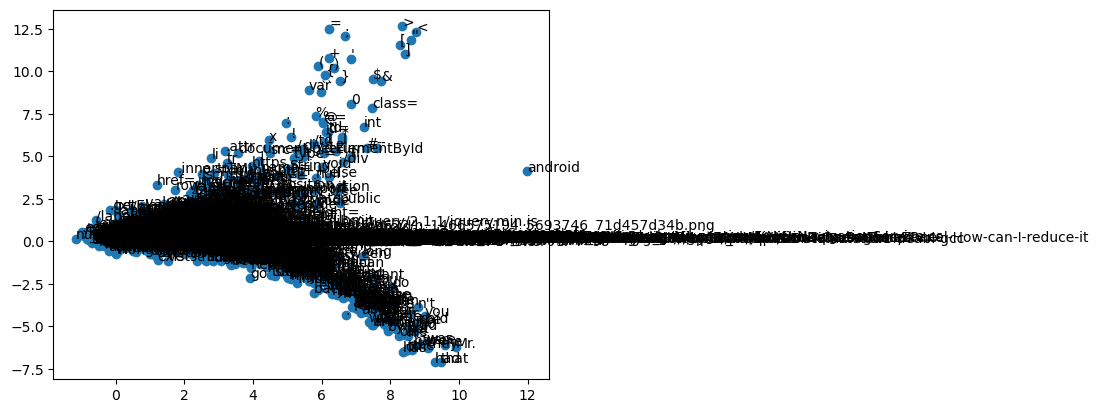

In [79]:
from matplotlib import pyplot
pyplot.rcParams["font.family"] = "DejaVu Sans"  # Use a font that supports a wide range of characters

pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.index_to_key)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [81]:
model.wv.similar_by_word("public", 3)
#model.similar_by_word("void", 3)
#model.similar_by_word("anyone", 3) 

[('private', 0.9510699510574341),
 ('static', 0.9500579833984375),
 ('getTypeface', 0.9417592883110046)]

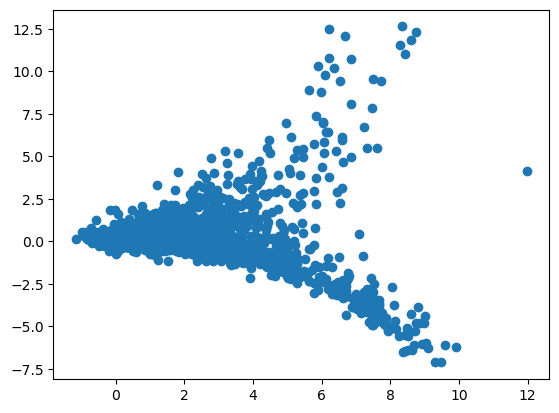

In [82]:
pyplot.scatter(result[:, 0], result[:, 1])
pyplot.show()

In [83]:
print(xtrain_tfidf_ngram.size)

120646


In [84]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train1, y_test = train_test_split(xtrain_tfidf_ngram, train_y, test_size=0.20)
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, y_train1)
y_pred = classifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))

[[ 253   22 1346]
 [  31   67  221]
 [   9    7 1587]]
              precision    recall  f1-score   support

           0       0.86      0.16      0.26      1621
           1       0.70      0.21      0.32       319
           2       0.50      0.99      0.67      1603

    accuracy                           0.54      3543
   macro avg       0.69      0.45      0.42      3543
weighted avg       0.69      0.54      0.45      3543



In [86]:
def create_word2vec_nn_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=False)
    
    # create hidden layer
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return classifier 

# classifier = create_word2vec_nn_architecture(X.size)
# accuracy = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, is_neural_net=True)
# print ("NN, Ngram Level TF IDF Vectors",accuracy)

In [87]:
print(X.shape)

(52291, 300)
